# RTC System Data
## Import Libraries

In [3]:
# Upgrade command
!pip install --upgrade pip

# Install Requests
!pip install requests

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import json
import requests
import datetime
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from collections import namedtuple
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pyplot import figure

### Latitude, Longitude & TZ

In [5]:
# Specify Location (Albuquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

## Accessing API with Pandas
### Weather and System Data

In [6]:
# Get Weather Data from URL - June 16
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/weather/start/2020-06-10/end/2020-06-11/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
weather_df = pd.DataFrame(response.json())
weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,RainDailyAccumilation,RelativeHumidity,TmStamp,WindDirection,WindSpeed
0,18.860001,-8.084993,-0.235385,-6.126448,0.0,16.969999,1591747260000,300.500000,2.141
1,18.830000,-7.097019,-0.040396,-6.076873,0.0,16.900000,1591747320000,297.899994,2.139
2,18.860001,-8.101092,-0.280232,-6.134745,0.0,16.680000,1591747380000,298.600006,2.349
3,18.850000,-7.009952,-0.112792,-6.257429,0.0,16.680000,1591747440000,300.100006,1.974
4,18.830000,-8.035944,-0.150115,-6.191267,0.0,16.670000,1591747500000,279.500000,1.570


In [7]:
# Drop unnecessary data
weather_df.drop(['RainDailyAccumilation', 'RelativeHumidity', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,TmStamp
0,18.860001,-8.084993,-0.235385,-6.126448,1591747260000
1,18.830000,-7.097019,-0.040396,-6.076873,1591747320000
2,18.860001,-8.101092,-0.280232,-6.134745,1591747380000
3,18.850000,-7.009952,-0.112792,-6.257429,1591747440000
4,18.830000,-8.035944,-0.150115,-6.191267,1591747500000


In [8]:
weather_df.rename(columns={'TmStamp':'TimeStamp', 'GlobalIrrad':'GHI', 'DirectIrrad':'DNI', 'DiffuseIrrad':'DHI'}, inplace=True)

In [9]:
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,18.860001,-8.084993,-0.235385,-6.126448,1591747260000
1,18.830000,-7.097019,-0.040396,-6.076873,1591747320000
2,18.860001,-8.101092,-0.280232,-6.134745,1591747380000
3,18.850000,-7.009952,-0.112792,-6.257429,1591747440000
4,18.830000,-8.035944,-0.150115,-6.191267,1591747500000


In [10]:
# Examine the types of the column labels
all(isinstance(column, str) for column in weather_df.columns)

True

In [11]:
weather_df['TimeStamp'] =  pd.to_datetime(weather_df['TimeStamp']/1000, unit='s')
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,18.860001,-8.084993,-0.235385,-6.126448,2020-06-10 00:01:00
1,18.830000,-7.097019,-0.040396,-6.076873,2020-06-10 00:02:00
2,18.860001,-8.101092,-0.280232,-6.134745,2020-06-10 00:03:00
3,18.850000,-7.009952,-0.112792,-6.257429,2020-06-10 00:04:00
4,18.830000,-8.035944,-0.150115,-6.191267,2020-06-10 00:05:00


In [12]:
# TimeStamp as Index
weather_df.set_index('TimeStamp', inplace=True)
weather_df.head()

,AmbientTemp,DHI,DNI,GHI
TimeStamp,,,,
2020-06-10 00:01:00,18.860001,-8.084993,-0.235385,-6.126448
2020-06-10 00:02:00,18.830000,-7.097019,-0.040396,-6.076873
2020-06-10 00:03:00,18.860001,-8.101092,-0.280232,-6.134745
2020-06-10 00:04:00,18.850000,-7.009952,-0.112792,-6.257429
2020-06-10 00:05:00,18.830000,-8.035944,-0.150115,-6.191267


In [13]:
# Weather Keys
print("Keys of weather_df: \n{}".format(weather_df.keys()))

Keys of weather_df: 
Index(['AmbientTemp', 'DHI', 'DNI', 'GHI'], dtype='object')


In [14]:
# Analyzing Data - June 16
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
weather_df.describe()

,AmbientTemp,DHI,DNI,GHI
count,1439.000000,1439.000000,1439.000000,1439.000000
mean,22.890320,20.458169,521.612294,375.289753
std,5.544078,24.599129,469.596250,415.185020
min,13.240000,-11.939549,-0.356734,-7.490970
25%,17.660000,-7.059908,0.064276,-5.954234
50%,23.629999,30.307014,704.275146,184.751114
75%,28.075000,45.087753,1003.345428,801.568359
max,31.969999,49.422245,1046.716675,1067.571899


In [15]:
weather_df_slice = weather_df.iloc[::5] 

## System

In [16]:
# Get System Data from URL - June 16
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/system/start/2020-06-10/end/2020-06-11/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
system_df = pd.DataFrame(response.json())
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TmStamp
0,17.316668,-3.476246,0.0,0.0,-0.048,2.400000,-2.496688,0.006,2.200000,0.0,1591747260000
1,17.366667,-3.476246,0.0,0.0,-0.048,2.466667,-2.643605,0.006,2.350000,0.0,1591747320000
2,17.400000,-3.476246,0.0,0.0,-0.048,2.816667,-2.716733,0.006,2.466667,0.0,1591747380000
3,17.433332,-3.476246,0.0,0.0,-0.048,2.766666,-2.716873,0.006,2.316667,0.0,1591747440000
4,17.408333,-3.476246,0.0,0.0,-0.048,2.716666,-2.569931,0.006,2.216667,0.0,1591747500000


In [17]:
# System Keys
print("Keys of system_df: \n{}".format(system_df.keys()))

Keys of system_df: 
Index(['AmbientTemp', 'PyranometerIrrad', 'RefCell1Irrad', 'RefCell2Irrad',
       'Sys1Idc', 'Sys1Vdc', 'Sys1Wac', 'Sys2Idc', 'Sys2Vdc', 'Sys2Wac',
       'TmStamp'],
      dtype='object')


In [18]:
system_df.rename(columns={'TmStamp':'TimeStamp'}, inplace=True)

In [19]:
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,17.316668,-3.476246,0.0,0.0,-0.048,2.400000,-2.496688,0.006,2.200000,0.0,1591747260000
1,17.366667,-3.476246,0.0,0.0,-0.048,2.466667,-2.643605,0.006,2.350000,0.0,1591747320000
2,17.400000,-3.476246,0.0,0.0,-0.048,2.816667,-2.716733,0.006,2.466667,0.0,1591747380000
3,17.433332,-3.476246,0.0,0.0,-0.048,2.766666,-2.716873,0.006,2.316667,0.0,1591747440000
4,17.408333,-3.476246,0.0,0.0,-0.048,2.716666,-2.569931,0.006,2.216667,0.0,1591747500000


In [20]:
system_df.tail()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
1434,22.508331,-2.317497,0.0,0.0,-0.045,2.200000,-2.571969,0.006,1.716667,0.0,1591833300000
1435,22.466665,-2.317497,0.0,0.0,-0.045,2.216667,-2.572061,0.006,1.783333,0.0,1591833360000
1436,22.666666,-2.317497,0.0,0.0,-0.045,2.316667,-2.645509,0.006,1.783333,0.0,1591833420000
1437,22.641665,-2.317497,0.0,0.0,-0.045,2.200000,-2.645719,0.006,1.666667,0.0,1591833480000
1438,22.574999,-2.317497,0.0,0.0,-0.045,2.200000,-2.572212,0.006,1.816667,0.0,1591833540000


In [21]:
# Examine the types of the column labels
all(isinstance(column, str) for column in system_df.columns)

True

In [22]:
system_df['TimeStamp'] =  pd.to_datetime(system_df['TimeStamp']/1000, unit='s')
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,17.316668,-3.476246,0.0,0.0,-0.048,2.400000,-2.496688,0.006,2.200000,0.0,2020-06-10 00:01:00
1,17.366667,-3.476246,0.0,0.0,-0.048,2.466667,-2.643605,0.006,2.350000,0.0,2020-06-10 00:02:00
2,17.400000,-3.476246,0.0,0.0,-0.048,2.816667,-2.716733,0.006,2.466667,0.0,2020-06-10 00:03:00
3,17.433332,-3.476246,0.0,0.0,-0.048,2.766666,-2.716873,0.006,2.316667,0.0,2020-06-10 00:04:00
4,17.408333,-3.476246,0.0,0.0,-0.048,2.716666,-2.569931,0.006,2.216667,0.0,2020-06-10 00:05:00


In [23]:
system_df.drop(system_df.index[range(0, 359)], axis=0, inplace=True)

In [24]:
# TimeStamp as Index
system_df.set_index('TimeStamp', inplace=True)
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-10 06:00:00,15.533333,41.425259,31.700098,31.049669,0.22050,322.250000,58.558975,0.25125,362.216644,69.126305
2020-06-10 06:01:00,15.674999,38.914639,31.928186,31.299004,0.22225,323.250000,59.124084,0.25325,362.583344,70.421844
2020-06-10 06:02:00,15.733333,36.307453,32.141460,31.518911,0.22325,327.616669,61.093182,0.25750,360.599976,68.133095
2020-06-10 06:03:00,15.816667,34.762455,32.385700,31.768541,0.22425,330.833344,61.821625,0.26100,360.733307,72.305946
2020-06-10 06:04:00,15.758332,34.762455,32.644703,32.003262,0.22525,332.716644,62.846539,0.26225,360.699982,72.592979


In [25]:
# Analyzing Data
system_df.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,25.164930,428.128505,412.917352,410.138694,3.378358,253.504747,1062.366111,3.405131,254.787557,1090.559023
std,4.027982,396.058687,392.321471,391.649439,3.227334,141.842126,989.838462,3.203004,146.993813,1006.753936
min,15.533333,-5.793742,0.000000,0.000000,-0.045000,2.200000,-3.011863,0.006000,1.566667,0.000000
25%,22.339584,-2.317497,0.000000,0.000000,-0.030062,211.045834,-2.350928,0.018375,46.199999,0.000000
50%,25.033333,377.269196,337.763763,331.506714,2.776000,320.758331,938.770813,2.804750,326.508331,968.591553
75%,29.068749,837.750977,823.101898,820.988541,6.768562,343.754158,2128.160583,6.749625,348.549957,2174.379883
max,31.383331,1016.898376,1002.648865,999.815918,8.231000,397.816650,2489.276611,8.233500,384.649994,2553.139893


In [26]:
system_df_slice = system_df.iloc[::5] 

In [27]:
system_df_slice.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-10 06:00:00,15.533333,41.425259,31.700098,31.049669,0.2205,322.250000,58.558975,0.25125,362.216644,69.126305
2020-06-10 06:05:00,15.866666,35.052143,32.843006,32.208782,0.2295,330.366669,63.870846,0.26350,361.083344,73.476433
2020-06-10 06:10:00,15.991666,37.659325,35.271275,33.324234,0.2555,331.533325,72.022903,0.29225,362.916656,83.977119
2020-06-10 06:15:00,16.449999,64.117416,43.395092,38.844685,0.2735,340.466644,80.419777,0.34100,345.333344,98.758575
2020-06-10 06:20:00,16.650000,79.181145,36.447357,37.017071,0.2850,361.199982,90.477272,0.38575,378.066650,122.840324


In [28]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,25.146026,428.274243,412.832650,410.053244,3.378428,254.222525,1062.216174,3.406867,255.471137,1090.640213
std,4.054845,396.593128,393.034384,392.327044,3.233692,141.749326,991.465204,3.210027,146.726223,1008.501015
min,15.533333,-5.793742,0.000000,0.000000,-0.045000,2.200000,-3.011863,0.006000,1.600000,0.000000
25%,22.289584,-2.317497,0.000000,0.000000,-0.022000,218.366669,-2.423429,0.020250,203.662501,0.000000
50%,25.008333,377.510590,337.722000,331.436020,2.773750,320.633331,940.638458,2.804750,326.833344,969.400055
75%,29.035416,837.775162,821.526703,821.051422,6.753312,343.595810,2128.160583,6.731437,348.141655,2174.516296
max,31.383331,1016.222412,1002.011536,999.181885,8.214999,395.716675,2484.956299,8.221499,384.649994,2546.229492


# Weather and System Plot
## Weather June 16

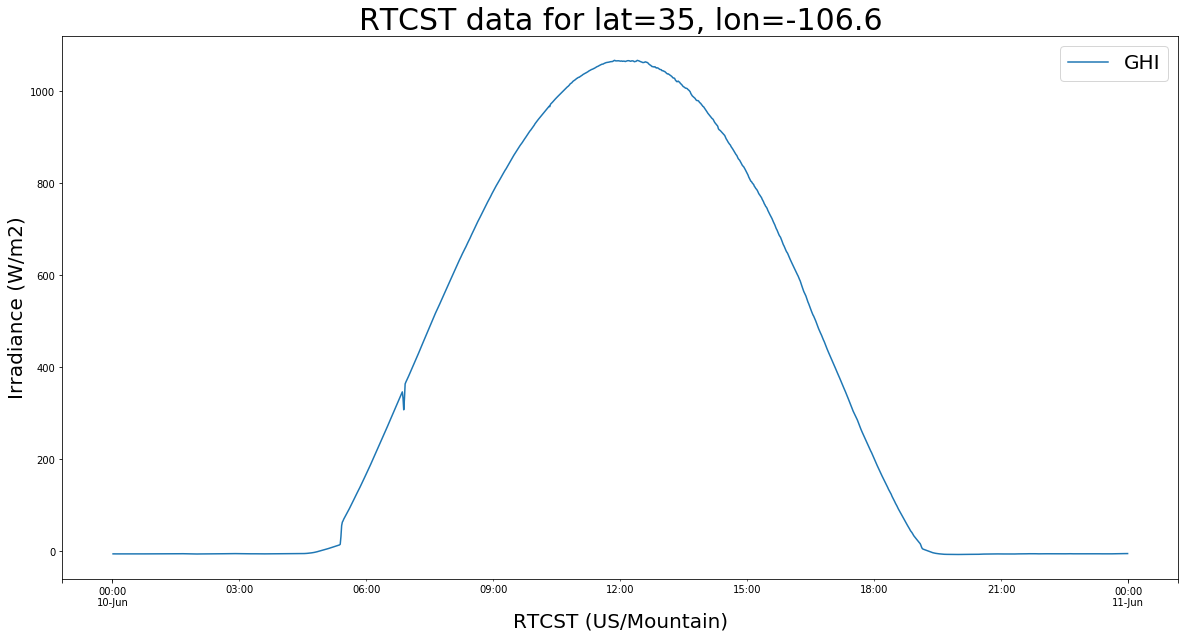

In [29]:
# Plot GHI
irrad_var = ['GHI']
weather_df[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

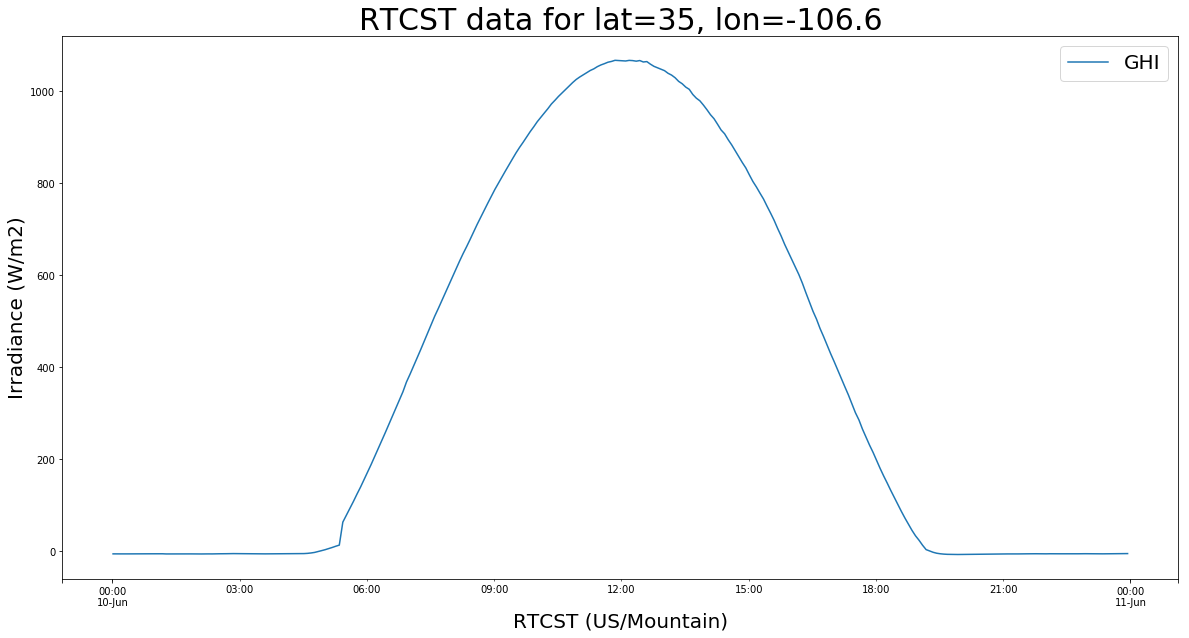

In [30]:
# Plot GHI
irrad_var = ['GHI']
weather_df_slice[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## System PIV June 16

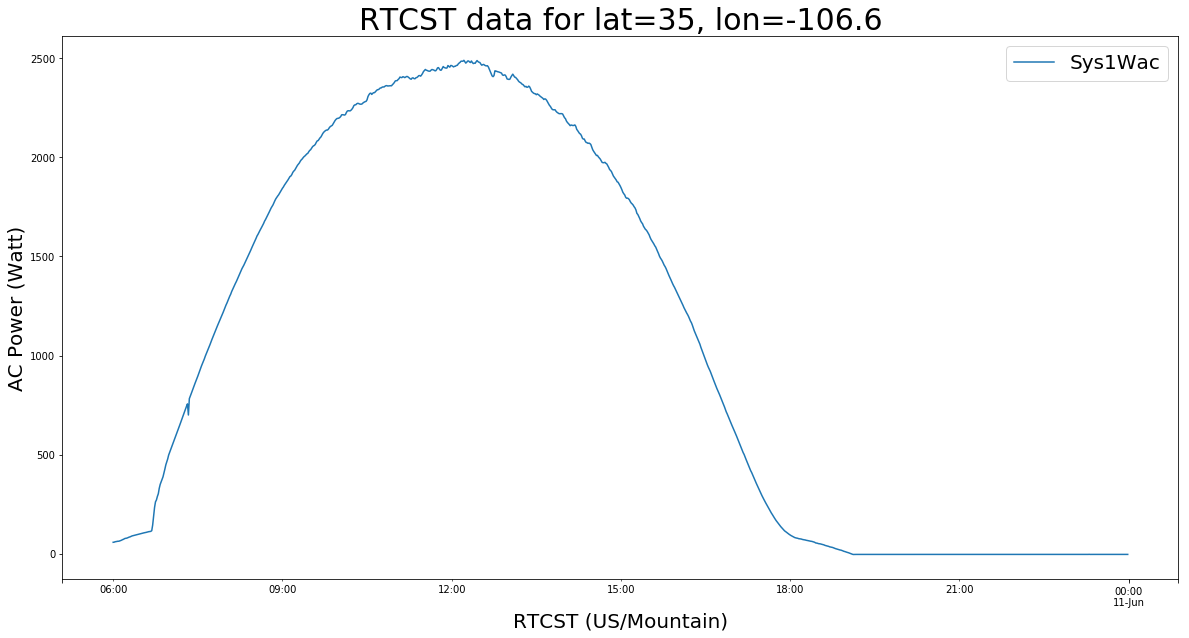

In [31]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

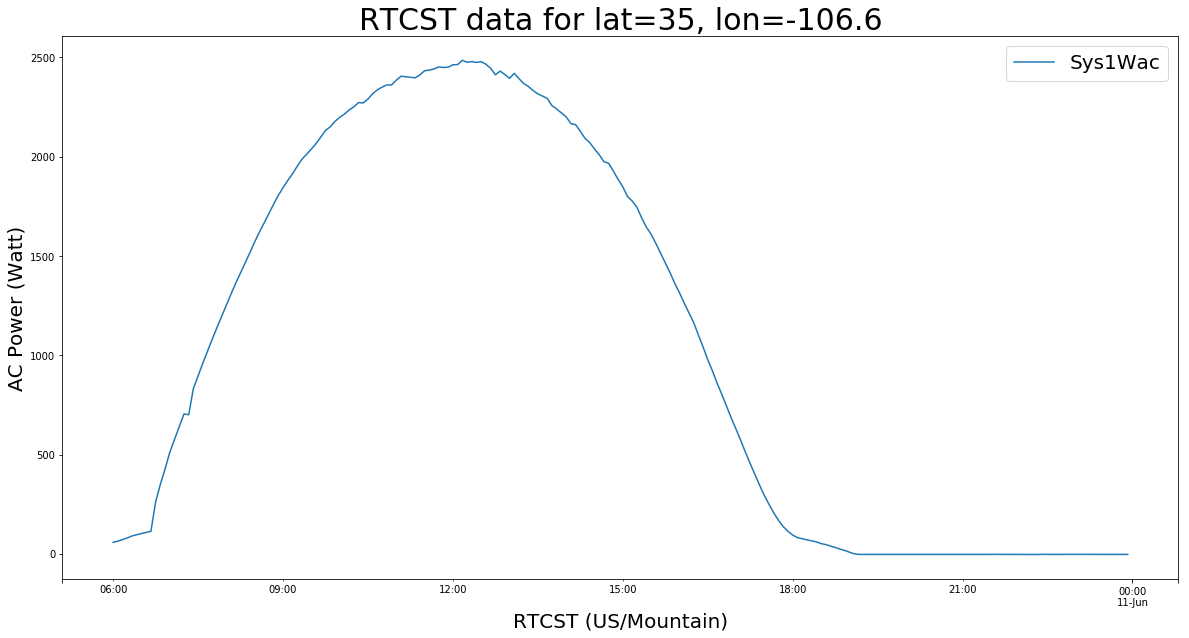

In [32]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

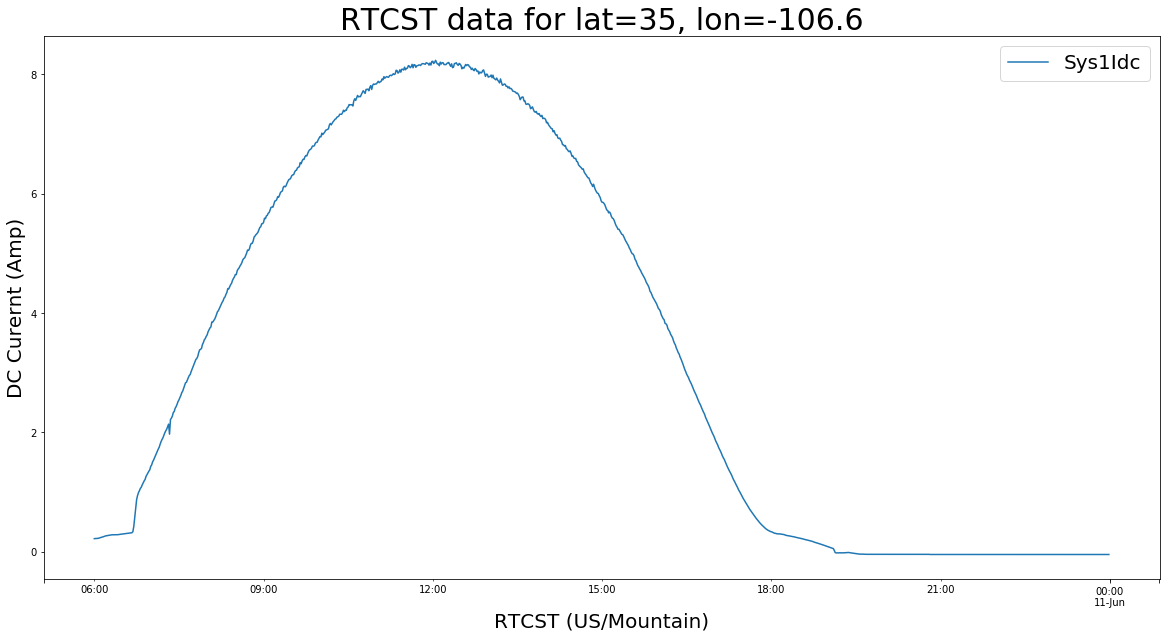

In [33]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

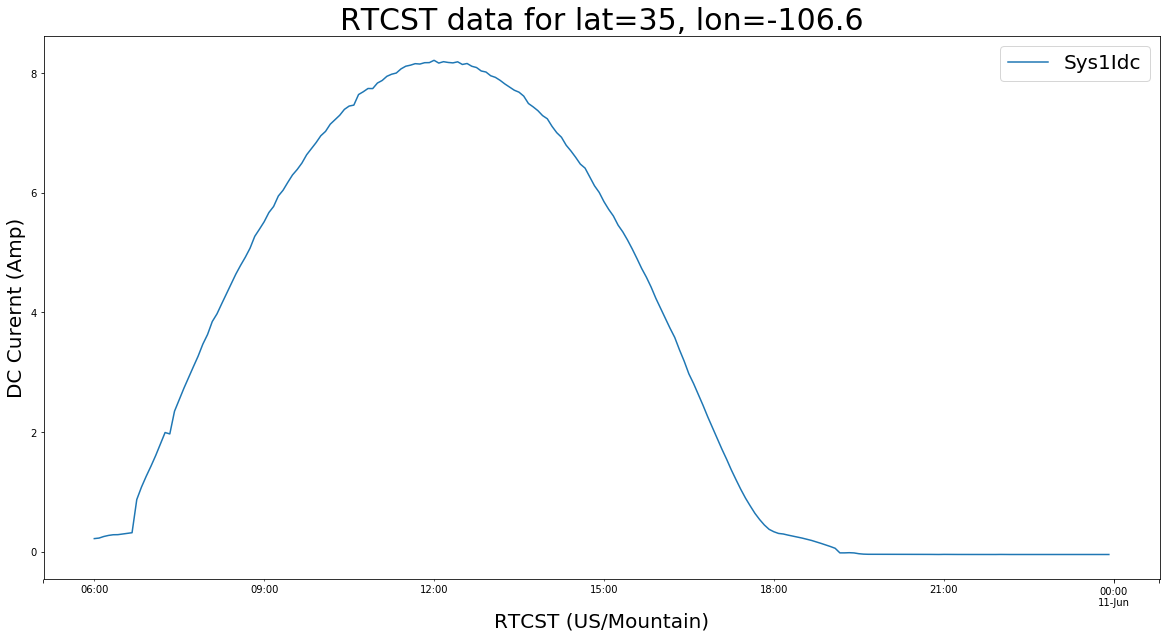

In [34]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

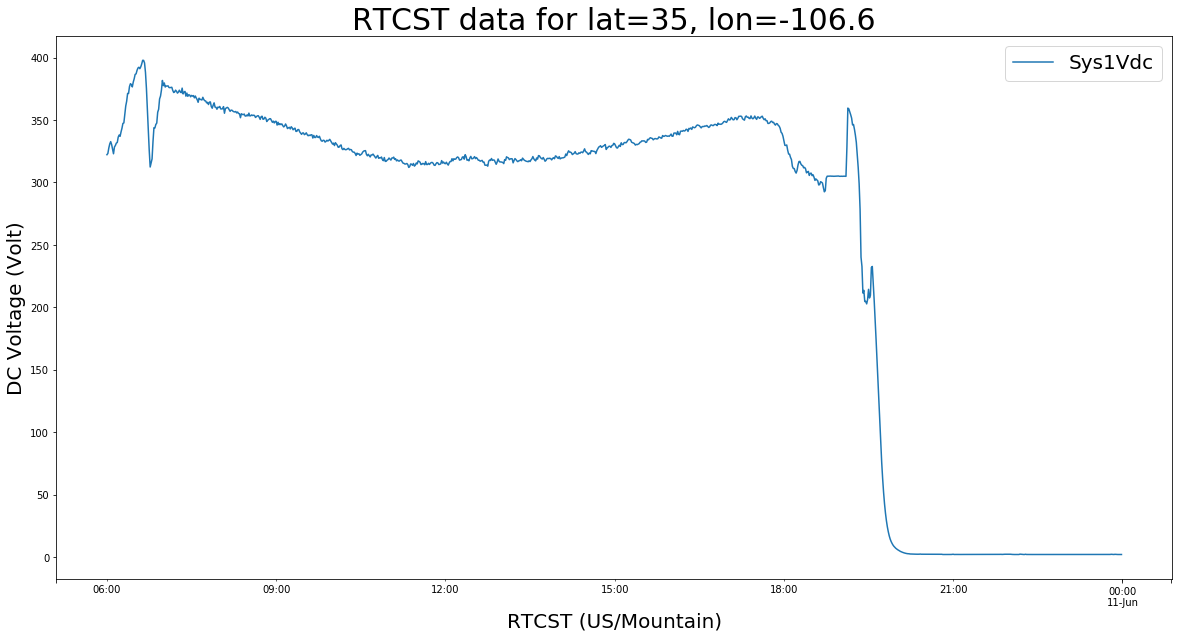

In [35]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

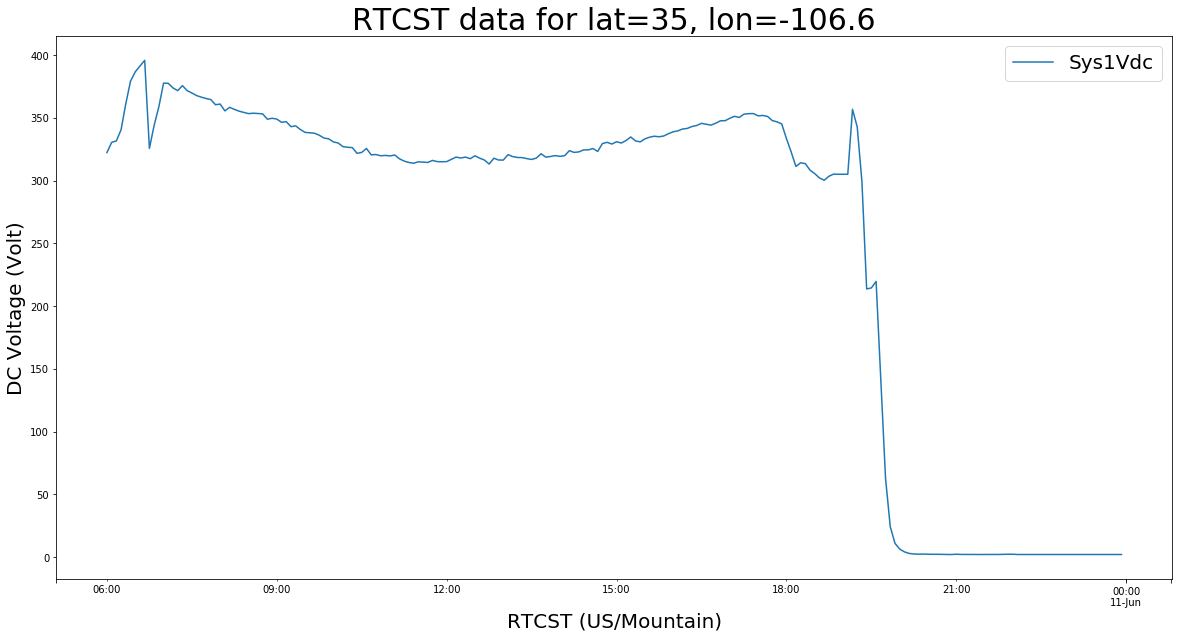

In [36]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df_slice[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## Read CSV's

In [37]:
# Read HRRR Irradiance CSV
hrrr_df = pd.read_csv('HRRR June 16.csv')
print("Keys of hrrr_df: \n{}".format(hrrr_df.keys()))

Keys of hrrr_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [38]:
hrrr_df.describe()

,ghi,dni,dhi
count,18.000000,18.000000,18.000000
mean,392.769675,300.464491,162.043731
std,367.915224,302.847301,140.140971
min,0.000000,0.000000,0.000000
25%,20.678188,0.000000,20.678188
50%,314.937962,255.176268,133.257653
75%,721.970735,606.635831,278.863389
max,974.948386,713.514111,390.603156


In [39]:
hrrr_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-15 06:00:00-06:00,0.201883,0.000000,0.201883
1,2020-06-15 07:00:00-06:00,53.293137,0.000000,53.293137
2,2020-06-15 08:00:00-06:00,145.114537,14.337201,139.386353
3,2020-06-15 09:00:00-06:00,267.500708,51.339664,237.562585
4,2020-06-15 10:00:00-06:00,475.443246,170.716038,348.687823


In [40]:
# Read Forecast AC Power CSV
ac_df = pd.read_csv('AC June 16.csv')
print("Keys of ac_df: \n{}".format(ac_df.keys()))

Keys of ac_df: 
Index(['2020-06-15 06:00:00-06:00', '-1.56'], dtype='object')


In [41]:
ac_df.head()

,2020-06-15 06:00:00-06:00,-1.56
0,2020-06-15 06:05:00-06:00,-1.56
1,2020-06-15 06:10:00-06:00,-1.56
2,2020-06-15 06:15:00-06:00,-1.56
3,2020-06-15 06:20:00-06:00,-1.56
4,2020-06-15 06:25:00-06:00,-1.56


In [42]:
# TimeStamp as Index
ac_df.set_index('2020-06-15 06:00:00-06:00', inplace=True)
ac_df.head()

,-1.56
2020-06-15 06:00:00-06:00,
2020-06-15 06:05:00-06:00,-1.56
2020-06-15 06:10:00-06:00,-1.56
2020-06-15 06:15:00-06:00,-1.56
2020-06-15 06:20:00-06:00,-1.56
2020-06-15 06:25:00-06:00,-1.56


In [43]:
ac_df.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_df.head()

,AC Power
2020-06-15 06:00:00-06:00,
2020-06-15 06:05:00-06:00,-1.56
2020-06-15 06:10:00-06:00,-1.56
2020-06-15 06:15:00-06:00,-1.56
2020-06-15 06:20:00-06:00,-1.56
2020-06-15 06:25:00-06:00,-1.56


In [45]:
ac_df.describe()

,AC Power
count,204.000000
mean,1337.315592
std,1071.876429
min,-17.538506
25%,63.824172
50%,1569.774072
75%,2417.573803
max,2657.873657


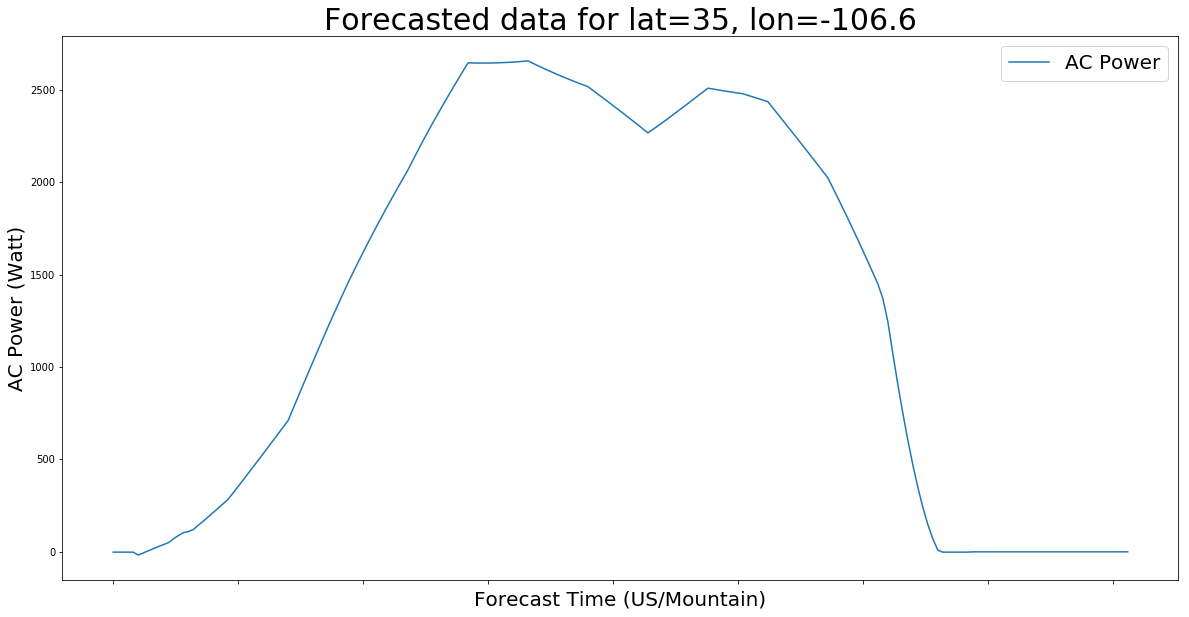

In [46]:
# Plot AC Power
forecast_ac = ['AC Power']
ac_df[forecast_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [47]:
# Read Forecast DC Power CSV
dc_df = pd.read_csv('DC June 16.csv')
print("Keys of dc_df: \n{}".format(dc_df.keys()))

Keys of dc_df: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [48]:
dc_df.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,2.496390,2.225104,643.427696,509.140625,1424.988491,2.438077,1.614903
std,1.970353,1.751497,309.622420,251.560436,1117.238231,1.925296,1.248082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.259976,0.235105,735.956235,565.751171,134.616473,0.253238,0.186792
50%,2.838078,2.537921,794.581739,631.938765,1682.788995,2.769476,1.900572
75%,4.511361,4.013009,807.285192,644.375582,2549.979428,4.407392,2.878820
max,4.919398,4.373043,821.908297,676.166815,2800.143365,4.807392,3.100925


In [49]:
dc_df.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-15 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-15 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-15 06:10:00-06:00,0.004966,0.004494,538.941132,0.000000,0.000000,0.004837,0.003593
3,2020-06-15 06:15:00-06:00,0.051487,0.046584,659.531467,384.758321,17.923506,0.050145,0.037199
4,2020-06-15 06:20:00-06:00,0.085294,0.077165,685.617172,450.655506,34.774948,0.083074,0.061569


### Merge DataFrames

In [52]:
# Clear Index
ac_df=ac_df.reset_index()
system_df_slice=system_df_slice.reset_index()

In [53]:
ac_df.head()

,2020-06-15 06:00:00-06:00,AC Power
0,2020-06-15 06:05:00-06:00,-1.56
1,2020-06-15 06:10:00-06:00,-1.56
2,2020-06-15 06:15:00-06:00,-1.56
3,2020-06-15 06:20:00-06:00,-1.56
4,2020-06-15 06:25:00-06:00,-1.56


In [54]:
system_df_slice.head()

,TimeStamp,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
0,2020-06-10 06:00:00,15.533333,41.425259,31.700098,31.049669,0.2205,322.250000,58.558975,0.25125,362.216644,69.126305
1,2020-06-10 06:05:00,15.866666,35.052143,32.843006,32.208782,0.2295,330.366669,63.870846,0.26350,361.083344,73.476433
2,2020-06-10 06:10:00,15.991666,37.659325,35.271275,33.324234,0.2555,331.533325,72.022903,0.29225,362.916656,83.977119
3,2020-06-10 06:15:00,16.449999,64.117416,43.395092,38.844685,0.2735,340.466644,80.419777,0.34100,345.333344,98.758575
4,2020-06-10 06:20:00,16.650000,79.181145,36.447357,37.017071,0.2850,361.199982,90.477272,0.38575,378.066650,122.840324


In [55]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_df['System']=system
ac_df.head()

,2020-06-15 06:00:00-06:00,AC Power,System
0,2020-06-15 06:05:00-06:00,-1.56,58.558975
1,2020-06-15 06:10:00-06:00,-1.56,63.870846
2,2020-06-15 06:15:00-06:00,-1.56,72.022903
3,2020-06-15 06:20:00-06:00,-1.56,80.419777
4,2020-06-15 06:25:00-06:00,-1.56,90.477272


In [56]:
# TimeStamp as Index
ac_df.set_index('2020-06-15 06:00:00-06:00', inplace=True)
ac_df.head()

,AC Power,System
2020-06-15 06:00:00-06:00,,
2020-06-15 06:05:00-06:00,-1.56,58.558975
2020-06-15 06:10:00-06:00,-1.56,63.870846
2020-06-15 06:15:00-06:00,-1.56,72.022903
2020-06-15 06:20:00-06:00,-1.56,80.419777
2020-06-15 06:25:00-06:00,-1.56,90.477272


In [58]:
# Examine the column labels
all(isinstance(column, str) for column in ac_df.columns)

True

## Plot Data

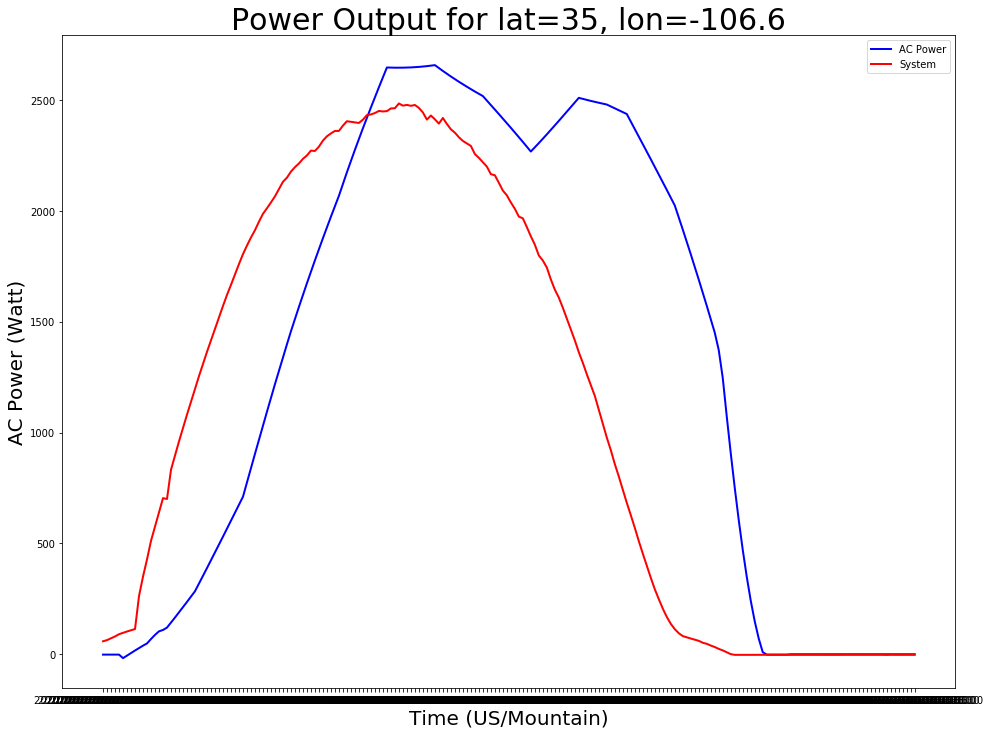

In [60]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_df, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_df, marker='', color='red', linewidth=2);
plt.legend();

## Error
### Mean Square Error

In [ ]:
y_true= system_df_slice['Sys1Wac']
y_pred= ac_df['AC Power']
print('Mean Square Error:\n',mean_squared_error(y_true, y_pred))